In [4]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from joblib import Parallel, delayed
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [5]:
mcdonalds = pd.read_csv("C:/Users/win/Desktop/Feynn Labs/t1/mcdonalds.csv")

# Print the column names
print(mcdonalds.columns.tolist())

['yummy', 'convenient', 'spicy', 'fattening', 'greasy', 'fast', 'cheap', 'tasty', 'expensive', 'healthy', 'disgusting', 'Like', 'Age', 'VisitFrequency', 'Gender']


In [6]:
mcdonalds.shape

(1453, 15)

In [7]:
mcdonalds.head(3)

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female


In [8]:
# Select the first 11 columns
md = mcdonalds.iloc[:, :11]

# Convert 'Yes'/'No' to 1/0
mdx = md.replace({'Yes':1, 'No':0})

# Calculate the column means
col_means = mdx.mean().round(2)

# Print the column means
print(col_means)

yummy         0.55
convenient    0.91
spicy         0.09
fattening     0.87
greasy        0.53
fast          0.90
cheap         0.60
tasty         0.64
expensive     0.36
healthy       0.20
disgusting    0.24
dtype: float64


In [9]:
type(mdx)

pandas.core.frame.DataFrame

In [10]:
# Perform PCA
pca = PCA()
pca_results = pca.fit_transform(mdx)

# Extract PCA results
standard_deviation = np.sqrt(pca.explained_variance_)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Create a DataFrame for the PCA summary
pca_summary = pd.DataFrame({
    'Standard deviation': standard_deviation,
    'Proportion of Variance': explained_variance,
    'Cumulative Proportion': cumulative_variance
}, index=[f'PC{i+1}' for i in range(len(standard_deviation))])

# Print the PCA summary
print(pca_summary.round(5))  # R rounds to 5 decimal places

      Standard deviation  Proportion of Variance  Cumulative Proportion
PC1              0.75705                 0.29945                0.29945
PC2              0.60746                 0.19280                0.49224
PC3              0.50462                 0.13305                0.62529
PC4              0.39880                 0.08310                0.70839
PC5              0.33741                 0.05948                0.76787
PC6              0.31027                 0.05030                0.81817
PC7              0.28970                 0.04385                0.86201
PC8              0.27512                 0.03955                0.90156
PC9              0.26525                 0.03676                0.93832
PC10             0.24884                 0.03235                0.97068
PC11             0.23690                 0.02932                1.00000


In [11]:
# Extract PCA results
standard_deviation = np.sqrt(pca.explained_variance_)
rotation_matrix = pca.components_.T * -1 # Transpose to match R's output format

# Create a DataFrame for the standard deviations
std_dev_df = pd.DataFrame({
    'Standard Deviation': standard_deviation
}, index=[f'PC{i+1}' for i in range(len(standard_deviation))])

# Create a DataFrame for the rotation matrix
rotation_df = pd.DataFrame(rotation_matrix, 
                           index=md.columns, 
                           columns=[f'PC{i+1}' for i in range(rotation_matrix.shape[1])])

# Print the standard deviations with 1 decimal place
print("Standard deviations (1, .., p=11):")
print(std_dev_df.round(1).to_string(index=False))

# Print the rotation matrix
print("\nRotation (n x k) = (11 x 11):")
print(rotation_df.round)

Standard deviations (1, .., p=11):
 Standard Deviation
                0.8
                0.6
                0.5
                0.4
                0.3
                0.3
                0.3
                0.3
                0.3
                0.2
                0.2

Rotation (n x k) = (11 x 11):
<bound method DataFrame.round of                  PC1       PC2       PC3       PC4       PC5       PC6  \
yummy       0.476933 -0.363790  0.304444 -0.055162  0.307535 -0.170738   
convenient  0.155332 -0.016414  0.062515  0.142425 -0.277608  0.347830   
spicy       0.006356 -0.018809  0.037019 -0.197619 -0.070620  0.355087   
fattening  -0.116232  0.034094  0.322359  0.354139  0.073405  0.406515   
greasy     -0.304443  0.063839  0.802373 -0.253960 -0.361399 -0.209347   
fast        0.108493  0.086972  0.064642  0.097363 -0.107930  0.594632   
cheap       0.337186  0.610633  0.149310 -0.118958  0.128973  0.103241   
tasty       0.471514 -0.307318  0.287265  0.002547  0.210899  0.07691

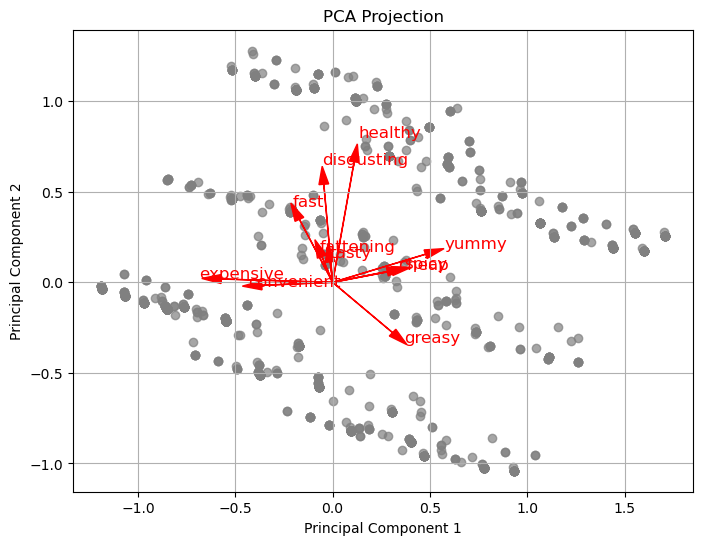

In [12]:
features = md.columns

# Plot the PCA projections
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], color='grey', alpha=0.7)
for i in range(rotation_matrix.shape[1]):
    plt.arrow(0, 0, rotation_matrix[0, i], rotation_matrix[1, i], color='red', head_width=0.05, head_length=0.1)
    plt.text(rotation_matrix[0, i]*1.2, rotation_matrix[1, i]*1.2, features[i], color='red', fontsize=12)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Projection')
plt.grid(True)
plt.show()

# Using K- means

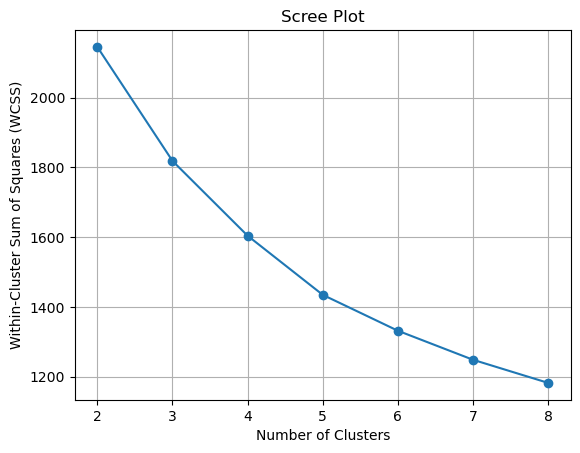

In [13]:
# Range of clusters to test
cluster_range = range(2, 9)

# Store WCSS for each number of clusters
wcss = []

# Perform k-means clustering for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    kmeans.fit(mdx)
    wcss.append(kmeans.inertia_)

# Plot the scree plot
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

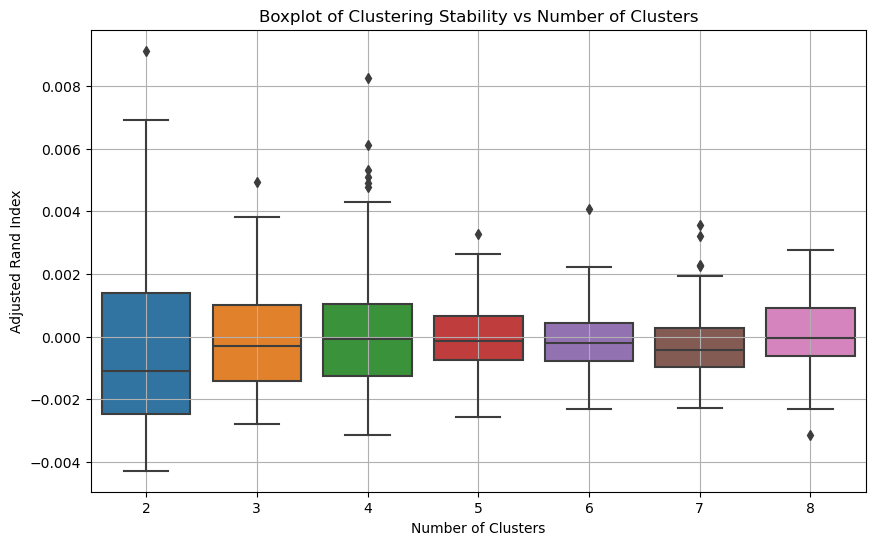

In [14]:
n_reps = 10
n_boot = 100

# Dictionary to store ARI scores for each number of clusters
ari_scores_dict = {n_clusters: [] for n_clusters in cluster_range}

# Function to compute clustering stability using ARI
def bootstrap_clusters(mdx, n_clusters, n_bootstraps):
    original_kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
    original_kmeans.fit(mdx)
    original_labels = original_kmeans.labels_
    
    ari_scores = []
    for _ in range(n_bootstraps):
        # Bootstrap sampling
        sample = resample(mdx, replace=True)
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=1234)
        kmeans.fit(sample)
        sample_labels = kmeans.labels_
        
        # Compute Adjusted Rand Index
        ari = adjusted_rand_score(original_labels, sample_labels)
        ari_scores.append(ari)
    
    return ari_scores

# Perform clustering and bootstrapping
for n_clusters in cluster_range:
    ari_scores = bootstrap_clusters(mdx, n_clusters, n_boot)
    ari_scores_dict[n_clusters].extend(ari_scores)

# Convert dictionary to DataFrame for plotting
ari_scores_df = pd.DataFrame([(n_clusters, score) for n_clusters, scores in ari_scores_dict.items() for score in scores],
                             columns=['Number of Clusters', 'ARI'])

# Plot the boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Number of Clusters', y='ARI', data=ari_scores_df)
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted Rand Index')
plt.title('Boxplot of Clustering Stability vs Number of Clusters')
plt.grid(True)
plt.show()

In [15]:
# Calculate the percentage of total points in each cluster
unique, counts = np.unique(labels, return_counts=True)
percentages = counts / len(labels) * 100

# Calculate the within-cluster variance (as a measure of similarity)
within_cluster_variance = []
for cluster_id in range(n_clusters):
    cluster_points = mdx[labels == cluster_id]
    cluster_center = kmeans.cluster_centers_[cluster_id]
    variance = np.mean(np.linalg.norm(cluster_points - cluster_center, axis=1)**2)
    within_cluster_variance.append(variance)

# Create the gorge plotany
plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), percentages, alpha=0.6, label='Percentage of Total Points')
plt.plot(range(n_clusters), within_cluster_variance, marker='o', color='r', label='Within-Cluster Variance')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total Points')
plt.title('Gorge Plot: Percentage of Total Points and Within-Cluster Variance')
plt.xticks(range(n_clusters))
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'labels' is not defined

In [ ]:
# Extracting the points belonging to the 4 clusters into md4 DataFrame
md4 = pd.DataFrame()
for cluster_id in range(n_clusters):
    cluster_points = mdx[labels == cluster_id]
    cluster_points['Cluster'] = cluster_id
    md4 = pd.concat([md4, cluster_points])

md4.reset_index(drop=True, inplace=True)
md4.head()  # Displaying the first few rows of the md4 DataFrame